# List of functions and packages

In [79]:
import os
import os.path
import pandas as pd
import numpy as np
import numbers
import time
from collections import defaultdict
from itertools import permutations

import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import clear_output
from IPython.display import display
%matplotlib inline


def read_kallisto_results_tpms(basedir):
    # Function to read kallisto results analysed with Genestack and save to pandas dataframe
    # input: 
    #       basedir = directory containing kallisto results exported from Genestack
    # output:
    #       df_reports = dataframe with filenames in columns and gene expression in rows
    reports = []
    metainfo = []
    for dirpath, dirnames, filenames in os.walk(basedir):
        for filename in [f for f in filenames if f.endswith(".tsv") and 'genes' in f]:
            reports.append(os.path.join(dirpath, filename))
        for filename in [f for f in filenames if f.endswith(".csv") and 'metainfo' in f and 'Kallisto' in f]:
            metainfo.append(os.path.join(dirpath, filename))

    print 'Number of reports found = ',len(reports), '\nName of first report:', reports[0]
    print 'Processing report #:'
    kallisto_counts = defaultdict()#(lambda: defaultdict())
    for i, filename in enumerate(reports):
        print i,
        if i%100 == 0 and i>0:
            clear_output()
        report = pd.read_csv(filename, sep = '\t')[['gene_id', 'tpm']]

        report = report[report.gene_id.str.startswith('ENSG')]
        kallisto_counts[reports[i].split('Kallisto_Report_for_')[1].split('/')[0]] = report
    df_reports = pd.DataFrame(kallisto_counts[kallisto_counts.keys()[0]].tpm.values, columns=[kallisto_counts.keys()[0]], 
                          index=kallisto_counts[kallisto_counts.keys()[0]].gene_id.values)

    for i, key in enumerate(kallisto_counts.keys()[1::]):
        df_reports[key] = kallisto_counts[key].tpm.values.copy()
        
    return df_reports, metainfo


def find_average_abundance_tissue(df):
    cl = [df.columns[x].split('_')[0] for x in range(len(df.columns))]
    df_reports_mean = df.copy()
    df_reports_mean.columns = cl

    df_reports_mean_all = df_reports_mean.groupby(by=df_reports_mean.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])
    return df_reports_mean_all


def get_correlation_other_tissue(df, label='datatype'):
    # FOR SINGLE EXPERIMENT
    # Helper function to calculate correlation between the same tissues
    # and correlation between given tissue and all the other tissues
    # input:
    #       df = pandas dataframe with tissue names in columns
    
    corrmat = df.corr()
    corr_tissue = defaultdict(set)
    for tissue in corrmat.columns:
        corr_tissue[tissue.split('_')[0]].update([corrmat[tissue][x] for x in corrmat[tissue].index if x.startswith(tissue[0:3]) and x not in tissue])

    corr_other_tissue = defaultdict(set)
    for tissue in corrmat.columns:
        corr_other_tissue[tissue.split('_')[0]].add(np.mean([corrmat[tissue][x] for x in corrmat[tissue].index if ~x.startswith(tissue[0:3]) and x not in tissue]))

    mean_corr = []
    mean_corr_other = []
    print "%-20s \t %-10s \t\t %s \t %-10s" % ('Tissue', 'number of comparisons', 'Correlation', 'Mean other tissues')
    for tissue in sorted(corr_tissue.keys()):
        mean_corr.append(np.mean(list(corr_tissue[tissue])))
        mean_corr_other.append(np.mean(list(corr_other_tissue[tissue])))
        print "%-20s \t\t %-10d \t\t %-10f \t %-10f" % (tissue, len(corr_tissue[tissue]), 
                                                                np.mean(list(corr_tissue[tissue])), 
                                                                np.mean(list(corr_other_tissue[tissue])))
    print 'Average within tissue correlation ('+label+' data) =', np.mean(mean_corr)
    print 'MEDIAN within tissue correlation across experiments =', np.median(mean_corr)

    print 'Average all other tissue correlation =', np.mean(mean_corr_other)
    print 'MEDIAN all other tissue correlation =', np.median(mean_corr_other)
    
    return mean_corr, mean_corr_other


def create_tissue_map(df):
    # Either for single or multiple experiments.
    # Function to create a tissue map for heatmaps
    # i.e. if there are multiple replicates of same tissue
    # it will return empty space
    # (so that it doesn't clog up heatmap axis labels)
    
    tissues_dict = defaultdict(list)
    for tis in sorted(df.columns.values):
        tissues_dict[tis.split('_')[0]].append(tis)
    tissues_map = []

    flatten = lambda l: [item for item in l]
    for tis in sorted(tissues_dict.keys()):
        if len(tissues_dict[tis])% 2 ==0:
            tissues_map.extend([flatten([""]*(int(np.floor(len(tissues_dict[tis])/2))-1)), 
                            [tis], flatten([""]*(int(np.floor(len(tissues_dict[tis])/2))))])
        else:
            tissues_map.extend([flatten([""]*int(np.floor(len(tissues_dict[tis])/2))), [tis], flatten([""]*int(np.floor(len(tissues_dict[tis])/2)))])

    flatten2 = lambda l: [item for sublist in l for item in sublist if sublist!=[]]
    return flatten2(tissues_map)


def within_tissue_correlation_heatmap(df, tissues_map, vmin = None):
    # FOR SINGLE EXPERIMENT
    # Function that calculate correlation
    # and display it as a heatmap
    
    tissues_dict = defaultdict(list)
    for tis in sorted(df.columns.values):
        tissues_dict[tis.split('_')[0]].append(tis)

    tissues_order = sorted(df.columns.values)

    corrmat = df.corr()
    corrmat = corrmat[tissues_order]
    corrmat = corrmat.reindex([tissues_order[::-1]])

    f, ax = plt.subplots(figsize=(5, 5))

    ax = plt.pcolor(corrmat, cmap= 'GnBu', alpha = 1, vmin = vmin)
    
    ttx = np.cumsum([len(tissues_dict[k]) for k in sorted(tissues_dict.keys())])
    tty = np.cumsum([len(tissues_dict[k]) for k in sorted(tissues_dict.keys())[::-1]])[::-1]
    plt.plot([0, ttx[0]], [tty[1], tty[1]], 'r-')
    plt.plot([ttx[0], ttx[0]], [tty[1], len(tissues_map)], 'r-')

    for x in range(1, len(ttx)-1):
        plt.plot([ttx[x], ttx[x]], [tty[x], tty[x+1]], 'r-')
        plt.plot([ttx[x-1], ttx[x]], [tty[x], tty[x]], 'r-')
        plt.plot([ttx[x-1], ttx[x]], [tty[x+1], tty[x+1]], 'r-')
        plt.plot([ttx[x-1], ttx[x-1]], [tty[x], tty[x+1]], 'r-')

    plt.plot([ttx[-2], len(tissues_map)], [tty[-1], tty[-1]], 'r-')
    plt.plot([ttx[-2], ttx[-2]], [0, tty[-1]], 'r-')
   
    plt.yticks(np.arange(0, len(corrmat.index), 1), tissues_map[::-1])
    plt.xticks(np.arange(0, len(corrmat.columns), 1), tissues_map, rotation=90)

    plt.colorbar(fraction=0.046, pad=0.04)
    f.tight_layout()

    
def print_corr_and_heatmap(df1, df2, label, show = True, vmin = None):
    mean_corr = []
    mean_corr_other = []
    print "%-20s \t\t %s \t %-10s" % ('Tissue', 'Correlation', 'Mean other tissues')
    common_genes = []
    for tissue in df1.keys():
        common_genes = np.intersect1d(df1[tissue].index, df2[tissue].index)
        mean_corr.append(np.corrcoef(df1[tissue].ix[common_genes], df2[tissue].ix[common_genes])[0, 1])
        mean_corr_other.append(df2[np.setdiff1d(df2.columns.values, tissue)].ix[common_genes].corrwith(df1[tissue].ix[common_genes]).mean())
        print "%-20s \t\t %f \t %-10f" % (tissue, 
                                    np.corrcoef(df1[tissue].ix[common_genes], df2[tissue].ix[common_genes])[0, 1],
                                   df2[np.setdiff1d(df2.columns.values, tissue)].ix[common_genes].corrwith(df1[tissue].ix[common_genes]).mean())
    print 'Average within tissue correlation across experiments ('+label+' data) =', np.mean(mean_corr)
    print 'MEDIAN within tissue correlation across experiments ('+label+' data) =', np.median(mean_corr)
    print 'Average all other tissue correlation =', np.mean(mean_corr_other)
    print 'MEDIAN all other tissue correlation =', np.median(mean_corr_other)

    df2_ren = df2.ix[common_genes].copy()
    df2_ren.columns = [col+'_2' for col in df2.columns]
    df12 = pd.concat([df1.ix[common_genes], df2_ren], axis = 1)
    if show:
        tissues_map = create_tissue_map(df12)
        within_tissue_correlation_heatmap(df12, tissues_map, vmin=vmin)
    return np.mean(mean_corr), np.mean(mean_corr_other)


def print_corr_and_heatmap_3exp(df1, df2, df3, label, show = True, vmin = None):
    mean_corr = []
    mean_corr_other = []
    print "%-20s \t\t %s \t %-10s" % ('Tissue', 'Correlation', 'Mean other tissues')
    for tissue in df1.keys():
        common_genes = np.intersect1d(np.intersect1d(df1[tissue].index, df2[tissue].index), df3[tissue].index)
        mean_corr.append(np.mean([np.mean([np.corrcoef(df1[tissue].ix[common_genes], df2[tissue].ix[common_genes])[0, 1],
                         np.corrcoef(df1[tissue].ix[common_genes], df3[tissue].ix[common_genes])[0, 1]]), 
                         np.corrcoef(df2[tissue].ix[common_genes], df3[tissue].ix[common_genes])[0, 1]]))
        mean_corr_other.append(
            np.mean([df3[np.setdiff1d(df3.columns.values, tissue)].ix[common_genes].corrwith(df1[tissue].ix[common_genes]).mean(),
                            df3[np.setdiff1d(df3.columns.values, tissue)].ix[common_genes].corrwith(df2[tissue].ix[common_genes]).mean(),
                            df2[np.setdiff1d(df2.columns.values, tissue)].ix[common_genes].corrwith(df1[tissue].ix[common_genes]).mean()])
        )
        print "%-20s \t\t %f \t %-10f" % (tissue, 
                                np.mean([np.mean([np.corrcoef(df1[tissue].ix[common_genes], df2[tissue].ix[common_genes])[0, 1],
                                     np.corrcoef(df1[tissue].ix[common_genes], df3[tissue].ix[common_genes])[0, 1]]), 
                                     np.corrcoef(df2[tissue].ix[common_genes], df3[tissue].ix[common_genes])[0, 1]]),
                                np.mean([df3[np.setdiff1d(df3.columns.values, tissue)].ix[common_genes].corrwith(df1[tissue].ix[common_genes]).mean(),
                                    df3[np.setdiff1d(df3.columns.values, tissue)].ix[common_genes].corrwith(df2[tissue].ix[common_genes]).mean(),
                                    df2[np.setdiff1d(df2.columns.values, tissue)].ix[common_genes].corrwith(df1[tissue].ix[common_genes]).mean()]))
    print 'Average within tissue correlation across experiments ('+label+' data) =', np.mean(mean_corr)
    print 'MEDIAN within tissue correlation across experiments ('+label+' data) =', np.median(mean_corr)
    print 'Average all other tissue correlation =', np.mean(mean_corr_other)
    print 'MEDIAN all other tissue correlation =', np.median(mean_corr_other)

    df2_ren = df2.ix[common_genes].copy()
    df2_ren.columns = [col+'_2' for col in df2.columns]
    
    df3_ren = df3.ix[common_genes].copy()
    df3_ren.columns = [col+'_3' for col in df3.columns]

    df123 = pd.concat([df1.ix[common_genes], df2_ren, df3_ren], axis = 1)
    if show:
        tissues_map = create_tissue_map(df123)
        within_tissue_correlation_heatmap(df123, tissues_map, vmin=vmin)
    return mean_corr, mean_corr_other
        

# below are different normalization methods        
def get_yugene_score(df):
    CumProp = pd.DataFrame(columns = df.columns)
    for col in df.columns.values:
        sample = df[col]
        sample2 = sample.copy().sort_values(ascending=False, kind = 'heapsort')
        sample3 = sample2.copy().cumsum().div(sample.sum(axis=0))
        sample3.loc[sample2.duplicated().values] = sample3[np.nonzero(sample2.duplicated().values)[0]-1].values
        CumProp[col] = 1-sample3[sample.index]
    return CumProp


def get_ef_score(df):
    return 2*(df - df.mean()) / (df + df.mean())


def get_rank_score(df):
    return df.rank(axis = 0)/ len(df)


def get_zscore_score(df):
    return (df - df.mean()) /df.std()


def get_quantile_score(df):
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()


def get_sigmoid(df):
    return 2/(1 + np.exp(-2*df/df.quantile(0.999))) + 1

# 1. Experiment 1: [E-MTAB-513] Illumina Human Body Map 2.0 Project (on Genestack GSF099976)

### 1.1 Load libraries and find kallisto reports  and kallisto metainfo for the experiment GSF099976 (48 samples)

In [2]:
basedir = './Experiment GSF099976/Exported_on_2017-02-06_13_45_52'

df_reports, metainfo = read_kallisto_results_tpms(basedir)
df_reports.head()

Number of reports found =  48 
Name of first report: ./Experiment GSF099976/Exported_on_2017-02-06_13_45_52/Kallisto_Report_for_E-MTAB-513_HCT20142/GSF3763918_kallisto_abundance_genes.tsv
Processing report #:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47

,E-MTAB-513_HCT20161_(1),E-MTAB-513_HCT20152_(1),E-MTAB-513_HCT20147_(1),E-MTAB-513_HCT20172_(4),E-MTAB-513_HCT20170_(1),E-MTAB-513_HCT20173_(4),E-MTAB-513_HCT20146_(1),E-MTAB-513_HCT20170_(3),E-MTAB-513_HCT20142_(1),E-MTAB-513_HCT20170,...,E-MTAB-513_HCT20162,E-MTAB-513_HCT20173_(1),E-MTAB-513_HCT20151,E-MTAB-513_HCT20150,E-MTAB-513_HCT20151_(1),E-MTAB-513_HCT20173_(3),E-MTAB-513_HCT20159,E-MTAB-513_HCT20158,E-MTAB-513_HCT20173_(5),E-MTAB-513_HCT20172_(2)
ENSG00000000003,34.62,40.79,32.88,52.57,35.74,49.95,8.75,36.41,30.58,35.69,...,25.46,51.22,58.58,55.49,61.10,49.48,11.58,44.56,49.78,49.89
ENSG00000000005,81.58,0.31,0.61,11.64,7.40,12.87,0.22,6.16,0.29,7.70,...,2.19,14.72,1.42,0.51,1.28,11.34,7.48,30.64,11.83,10.84
ENSG00000000419,35.61,76.06,48.96,70.55,44.57,39.85,27.28,43.51,46.30,46.31,...,33.49,42.36,62.67,51.89,65.13,38.86,39.75,27.43,41.71,68.08
ENSG00000000457,4.79,8.90,8.55,6.78,4.46,9.70,4.51,4.30,5.32,4.39,...,1.99,9.93,6.78,8.91,6.06,9.30,5.79,2.75,8.68,7.59
ENSG00000000460,2.07,2.44,2.48,3.37,2.13,3.85,1.71,1.86,1.93,1.95,...,0.91,3.93,16.21,2.95,16.91,3.91,1.53,2.36,3.90,3.48


### 1.2 Find additional metainfo (extracted separately from Genestack with python script `extract_metainfo_rnaexp.py`) with all the necessary fields (age, tissue type etc.)  and load to pandas dataframe `metainf`

In [3]:
metainf = pd.read_csv('/Users/eleonora/GitHub/rna-seq re-analysis/Public Experiments/Experiment GSF099976/metainfo.csv', sep = '\t',index_col=False)
metainf.head()

,genestack:accession,genestack:name,genestack.bio:sex,sourceData:geo.Channel.1.characteristic.age,sourceData:geo.Channel.1.characteristic.organismpart,sourceData:geo.Channel.1.characteristic.phenotype,sourceData:sra.library_name
0,GSF100024,E-MTAB-513:HCT20143,male,77 years,heart,caucasian,HCT20143
1,GSF100020,E-MTAB-513:HCT20146,female,86 years,lymph node,caucasian,HCT20146
2,GSF100021,E-MTAB-513:HCT20173,None,None,16 Tissues mixture,None,HCT20173
3,GSF100008,E-MTAB-513:HCT20149,male,58 years,white blood cells,caucasian,HCT20149
4,GSF100009,E-MTAB-513:HCT20173,None,None,16 Tissues mixture,None,HCT20173


### 1.3 Read kallisto reports to pandas dataframes and create dictionary kallisto_counts for each file accession. Do the same with kallisto metainfo and combine it with columns in additional metainfo.

In [4]:
kallisto_metainfo = defaultdict()
for i, filename in enumerate(metainfo):
    print i,
    if i%100 == 0 and i>0:
        clear_output()
    meta = pd.read_csv(filename, sep = ',')[['Source data', 'Name']]
    acc = meta['Source data'].values[0].split('/ ')[1]
    metainf.ix[metainf['genestack:accession']==acc ,'genestack:name'] = filename.split('Kallisto_Report_for_')[1].split('/')[0].split('__metainfo')[0]
    kallisto_metainfo[filename.split('Kallisto_Report_for_')[1].split('/')[0].split('__metainfo')[0]] = metainf[metainf['genestack:accession']==acc]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47


### 1.4 Create pandas dataframe for metainfo so we can map accessions with file names, convert age to integer numbers

In [5]:
df_meta = pd.DataFrame(kallisto_metainfo[kallisto_metainfo.keys()[0]], columns=[kallisto_metainfo.values()[0].columns])

for key in kallisto_metainfo.keys()[1::]:
    df_meta = pd.concat([df_meta, kallisto_metainfo[key].copy()])
df_meta = df_meta.reset_index(drop=True)

for row in df_meta.index:
    if df_meta.ix[row, 'sourceData:geo.Channel.1.characteristic.age'] == "None":
        continue
    df_meta.ix[row, 'sourceData:geo.Channel.1.characteristic.age'] =  int(df_meta.ix[row, 'sourceData:geo.Channel.1.characteristic.age'].split(' years')[0])
    
df_meta.head(3)

,genestack:accession,genestack:name,genestack.bio:sex,sourceData:geo.Channel.1.characteristic.age,sourceData:geo.Channel.1.characteristic.organismpart,sourceData:geo.Channel.1.characteristic.phenotype,sourceData:sra.library_name
0,GSF099979,E-MTAB-513_HCT20161_(1),female,29,breast,caucasian,HCT20161
1,GSF100004,E-MTAB-513_HCT20152_(1),female,60,thyroid,caucasian,HCT20152
2,GSF099984,E-MTAB-513_HCT20147_(1),male,73,prostate,caucasian,HCT20147


### 1.5 Substitute file names with tissues and calculate within tissue correlations

,breast_0,thyroid_0,prostate_0,16 Tissues mixture_0,16 Tissues mixture_2,16 Tissues mixture_3,lymph node_0,16 Tissues mixture_4,kidney_0,16 Tissues mixture_5,...,colon_2,16 Tissues mixture_13,testes_0,ovary_2,testes_2,16 Tissues mixture_14,adrenal_2,adipose_2,16 Tissues mixture_15,16 Tissues mixture_16
ENSG00000000003,34.62,40.79,32.88,52.57,35.74,49.95,8.75,36.41,30.58,35.69,...,25.46,51.22,58.58,55.49,61.10,49.48,11.58,44.56,49.78,49.89
ENSG00000000005,81.58,0.31,0.61,11.64,7.40,12.87,0.22,6.16,0.29,7.70,...,2.19,14.72,1.42,0.51,1.28,11.34,7.48,30.64,11.83,10.84
ENSG00000000419,35.61,76.06,48.96,70.55,44.57,39.85,27.28,43.51,46.30,46.31,...,33.49,42.36,62.67,51.89,65.13,38.86,39.75,27.43,41.71,68.08


Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adipose              		 1          		 0.945717   	 0.765732  
adrenal              		 1          		 0.952242   	 0.745021  
brain                		 1          		 0.980425   	 0.753189  
breast               		 1          		 0.940794   	 0.772893  
colon                		 1          		 0.972846   	 0.735266  
heart                		 1          		 0.907768   	 0.695129  
kidney               		 1          		 0.987845   	 0.749209  
liver                		 1          		 0.971826   	 0.494846  
lung                 		 1          		 0.918443   	 0.566077  
lymph node           		 1          		 0.961697   	 0.320581  
ovary                		 1          		 0.948377   	 0.689324  
prostate             		 1          		 0.844054   	 0.694653  
skeletal muscle      		 1          		 0.854872   	 0.719399  
testes               		 1          		 0.977626   	 0.761655  
thyroid              		 1          		 0.953123   	 

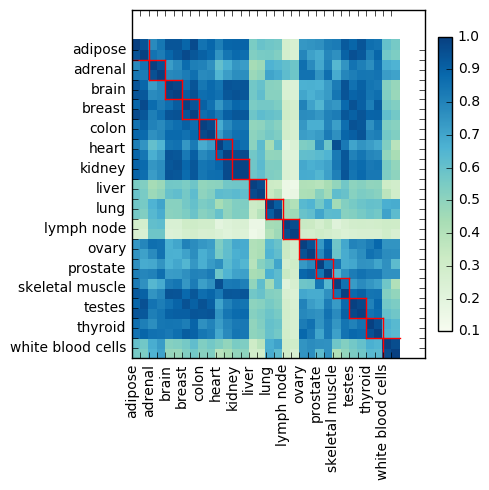

In [6]:
cl = [df_meta[df_meta['genestack:name']==x]['sourceData:geo.Channel.1.characteristic.organismpart'].values[0] for x in df_reports.columns]
df_reports2 = df_reports.copy()
df_reports2.columns = cl

# If there are duplicate columns - enumerate them and add "_number of duplicate" at the end of tissue name
cols=pd.Series(df_reports2.columns)
for dup in df_reports2.columns.get_duplicates(): cols[df_reports2.columns.get_loc(dup)]=[dup+'_'+str(d_idx+1) if d_idx!=0 else dup+'_0' for d_idx in range(df_reports2.columns.get_loc(dup).sum())]
df_reports2.columns=cols
display(df_reports2.head(3))

# this experiment had data from 16 mixed tissues, it's not really informative for our goal so let's remove it
df_reports2 = df_reports2[df_reports2.columns[~df_reports2.columns.str.startswith('16')]]

mm, mm2 = get_correlation_other_tissue(df_reports2, label='RAW')
tissues_map = create_tissue_map(df_reports2)
within_tissue_correlation_heatmap(df_reports2, tissues_map, vmin = 0.1)

### 1.6 Apply different normalization and calculate correlation

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adipose              		 1          		 0.989841   	 0.837303  
adrenal              		 1          		 0.981548   	 0.830152  
brain                		 1          		 0.990032   	 0.739980  
breast               		 1          		 0.987441   	 0.836325  
colon                		 1          		 0.989920   	 0.850809  
heart                		 1          		 0.987611   	 0.786407  
kidney               		 1          		 0.991523   	 0.820810  
liver                		 1          		 0.991470   	 0.674601  
lung                 		 1          		 0.988538   	 0.808023  
lymph node           		 1          		 0.977057   	 0.800664  
ovary                		 1          		 0.987366   	 0.836050  
prostate             		 1          		 0.991631   	 0.849256  
skeletal muscle      		 1          		 0.988041   	 0.750707  
testes               		 1          		 0.989443   	 0.783311  
thyroid              		 1          		 0.989913   	 

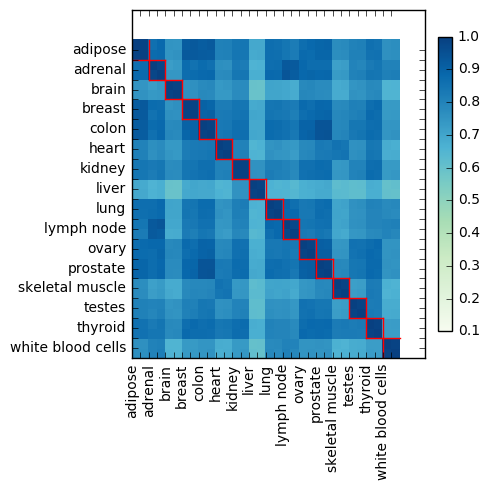

In [7]:
df_reports2_yugene = get_yugene_score(df_reports2)
mm, mm2 = get_correlation_other_tissue(df_reports2_yugene, label = 'YuGene')

tissues_map = create_tissue_map(df_reports2_yugene)
within_tissue_correlation_heatmap(df_reports2_yugene, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adipose              		 1          		 0.989966   	 0.867028  
adrenal              		 1          		 0.983394   	 0.858885  
brain                		 1          		 0.989254   	 0.789927  
breast               		 1          		 0.987221   	 0.869409  
colon                		 1          		 0.989466   	 0.870149  
heart                		 1          		 0.992850   	 0.822725  
kidney               		 1          		 0.991771   	 0.853890  
liver                		 1          		 0.993523   	 0.748154  
lung                 		 1          		 0.990137   	 0.841768  
lymph node           		 1          		 0.986974   	 0.846340  
ovary                		 1          		 0.987848   	 0.864050  
prostate             		 1          		 0.992478   	 0.876340  
skeletal muscle      		 1          		 0.992685   	 0.796403  
testes               		 1          		 0.989407   	 0.808159  
thyroid              		 1          		 0.989978   	 

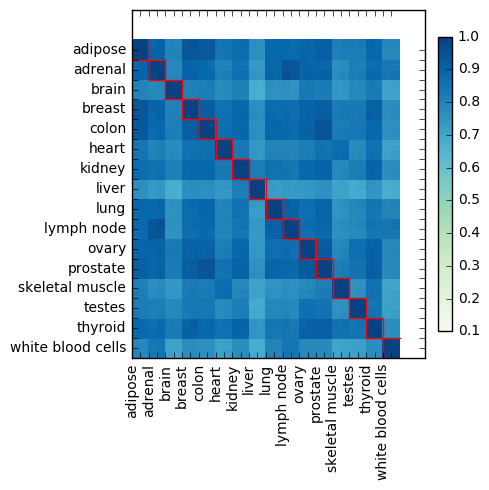

In [8]:
df_reports2_ef = get_ef_score(df_reports2)

mm = get_correlation_other_tissue(df_reports2_ef, 'EF trasformed')

tissues_map = create_tissue_map(df_reports2_ef)
within_tissue_correlation_heatmap(df_reports2_ef, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adipose              		 1          		 0.952219   	 0.882257  
adrenal              		 1          		 0.952125   	 0.875098  
brain                		 1          		 0.951816   	 0.845810  
breast               		 1          		 0.955484   	 0.885165  
colon                		 1          		 0.958107   	 0.884177  
heart                		 1          		 0.949577   	 0.872747  
kidney               		 1          		 0.957961   	 0.875958  
liver                		 1          		 0.954627   	 0.853343  
lung                 		 1          		 0.961313   	 0.873061  
lymph node           		 1          		 0.959640   	 0.875986  
ovary                		 1          		 0.955285   	 0.883210  
prostate             		 1          		 0.962359   	 0.887517  
skeletal muscle      		 1          		 0.947541   	 0.850461  
testes               		 1          		 0.960597   	 0.827530  
thyroid              		 1          		 0.955673   	 

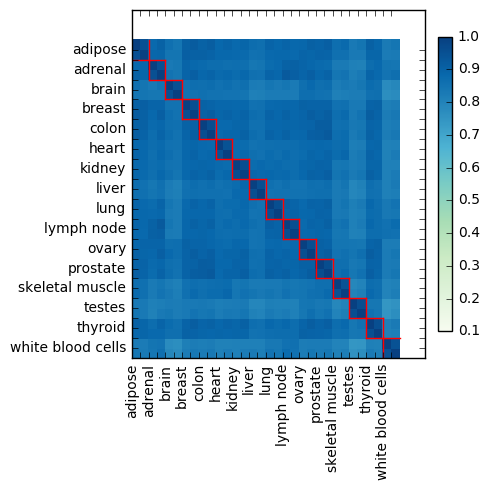

In [9]:
df_reports2_rank = get_rank_score(df_reports2)

mm = get_correlation_other_tissue(df_reports2_rank, 'RANKED')
tissues_map = create_tissue_map(df_reports2_rank)
within_tissue_correlation_heatmap(df_reports2_rank, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adipose              		 1          		 0.945717   	 0.765732  
adrenal              		 1          		 0.952242   	 0.745021  
brain                		 1          		 0.980425   	 0.753189  
breast               		 1          		 0.940794   	 0.772893  
colon                		 1          		 0.972846   	 0.735266  
heart                		 1          		 0.907768   	 0.695129  
kidney               		 1          		 0.987845   	 0.749209  
liver                		 1          		 0.971826   	 0.494846  
lung                 		 1          		 0.918443   	 0.566077  
lymph node           		 1          		 0.961697   	 0.320581  
ovary                		 1          		 0.948377   	 0.689324  
prostate             		 1          		 0.844054   	 0.694653  
skeletal muscle      		 1          		 0.854872   	 0.719399  
testes               		 1          		 0.977626   	 0.761655  
thyroid              		 1          		 0.953123   	 

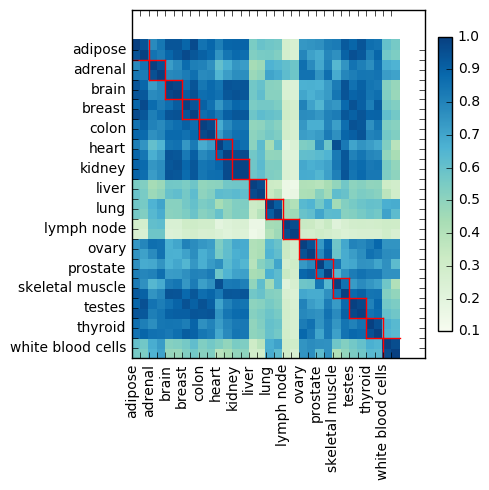

In [10]:
df_reports2_zscore = get_zscore_score(df_reports2)

mm = get_correlation_other_tissue(df_reports2_zscore, 'Z-score transformed')

tissues_map = create_tissue_map(df_reports2_zscore)
within_tissue_correlation_heatmap(df_reports2_zscore, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adipose              		 1          		 0.949742   	 0.776209  
adrenal              		 1          		 0.938566   	 0.753584  
brain                		 1          		 0.974198   	 0.762929  
breast               		 1          		 0.934519   	 0.780450  
colon                		 1          		 0.983841   	 0.768646  
heart                		 1          		 0.938975   	 0.716559  
kidney               		 1          		 0.986554   	 0.756820  
liver                		 1          		 0.962275   	 0.470234  
lung                 		 1          		 0.895199   	 0.537668  
lymph node           		 1          		 0.858773   	 0.470281  
ovary                		 1          		 0.919792   	 0.709035  
prostate             		 1          		 0.807039   	 0.716036  
skeletal muscle      		 1          		 0.814922   	 0.710773  
testes               		 1          		 0.986137   	 0.778821  
thyroid              		 1          		 0.935634   	 

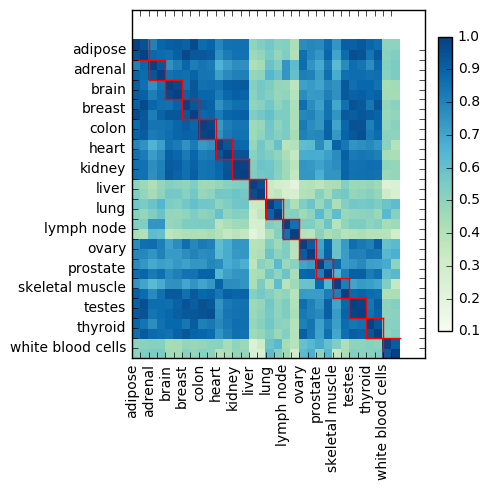

In [11]:
df_reports2_quantile = get_quantile_score(df_reports2)

mm = get_correlation_other_tissue(df_reports2_quantile, 'Quantile transformed')

tissues_map = create_tissue_map(df_reports2_quantile)
within_tissue_correlation_heatmap(df_reports2_quantile, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adipose              		 1          		 0.984884   	 0.801894  
adrenal              		 1          		 0.972613   	 0.790257  
brain                		 1          		 0.990040   	 0.674930  
breast               		 1          		 0.979533   	 0.785593  
colon                		 1          		 0.984802   	 0.808648  
heart                		 1          		 0.983441   	 0.650632  
kidney               		 1          		 0.980968   	 0.766058  
liver                		 1          		 0.982409   	 0.504398  
lung                 		 1          		 0.985753   	 0.760418  
lymph node           		 1          		 0.922771   	 0.699448  
ovary                		 1          		 0.984458   	 0.796364  
prostate             		 1          		 0.987515   	 0.800437  
skeletal muscle      		 1          		 0.987494   	 0.699299  
testes               		 1          		 0.983980   	 0.785107  
thyroid              		 1          		 0.982188   	 

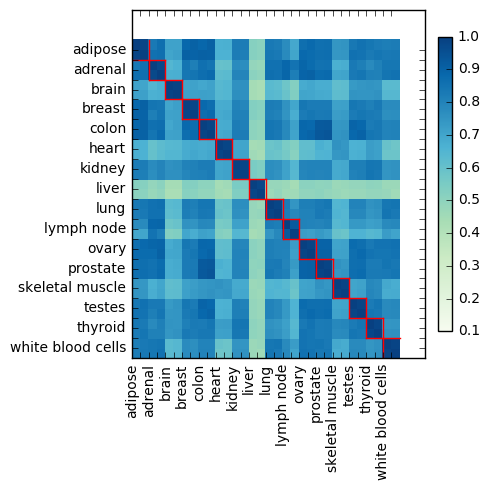

In [14]:
df_reports2_quantile = get_sigmoid(df_reports2)

mm = get_correlation_other_tissue(df_reports2_quantile, 'Sigmoid transformed')

tissues_map = create_tissue_map(df_reports2_quantile)
within_tissue_correlation_heatmap(df_reports2_quantile, tissues_map, vmin = 0.1)

### 1.7 Rename dataframes so its consistent across experiments

In [16]:
df_exp1_all = df_reports2.copy()

# calculate average values across replicates for same tissue
df_exp1_tissuelv = find_average_abundance_tissue(df_reports2).copy()

# 2.  Experiment 2: "HPA RNA-seq normal tissues" / GSF432860

In [17]:
basedir = './Experiment GSF432860'
# this experiment have tissue names as names of the files so no need for export metainfo
df_exp2_all, metainfo_exp2 = read_kallisto_results_tpms(basedir)

# calculate average values across replicates for same tissue
df_exp2_tissuelv = find_average_abundance_tissue(df_exp2_all).copy()

df_exp2_tissuelv.head()

 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170

,adrenal,appendix,bonemarrow,brain,colon,duodenum,endometrium,esophagus,fat,gallbladder,...,placenta,prostate,salivarygland,skin,smallintestine,spleen,stomach,testis,thyroid,urinarybladder
ENSG00000000003,29.478333,9.946667,0.90750,20.716667,56.521667,29.6250,46.612857,56.121667,38.560,45.835714,...,35.740000,51.338571,31.405000,8.675000,21.4375,14.178,19.6850,113.69250,53.117778,59.693333
ENSG00000000005,0.453333,1.428333,0.00000,0.250000,0.850000,0.2550,0.825714,0.541667,27.406,1.314286,...,5.874286,1.800000,0.220000,0.445000,0.3550,0.322,0.0425,0.70750,0.195556,0.203333
ENSG00000000419,76.593333,52.870000,41.83000,38.223333,41.081667,40.4625,72.860000,54.200000,40.116,60.018571,...,70.928571,57.207143,15.373333,44.088333,47.5775,48.180,34.6900,82.38625,93.124444,53.343333
ENSG00000000457,8.531667,10.998333,2.79375,7.763333,8.683333,8.5650,14.227143,8.985000,6.038,13.585714,...,11.820000,14.452857,3.265000,10.701667,8.2275,11.008,7.6275,14.68500,14.385556,10.063333
ENSG00000000460,3.256667,8.066667,8.12625,3.936667,3.403333,3.2400,7.427143,4.431667,3.560,5.242857,...,7.870000,4.987143,0.906667,5.420000,4.1050,5.456,2.9850,25.14000,4.670000,5.583333


### 2.1 Show heatmap and print within tissue correlation (correlation between replicates for the same tissue)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adrenal              		 15         		 0.977054   	 0.635842  
appendix             		 15         		 0.886764   	 0.583628  
bonemarrow           		 28         		 0.665027   	 0.157861  
brain                		 3          		 0.906303   	 0.585863  
colon                		 15         		 0.908290   	 0.618851  
duodenum             		 6          		 0.973542   	 0.626951  
endometrium          		 21         		 0.885715   	 0.570820  
esophagus            		 15         		 0.939684   	 0.391463  
fat                  		 10         		 0.991353   	 0.528888  
gallbladder          		 21         		 0.907412   	 0.631177  
heart                		 36         		 0.931913   	 0.555071  
kidney               		 6          		 0.952874   	 0.576868  
liver                		 10         		 0.950982   	 0.302630  
lung                 		 28         		 0.937843   	 0.364036  
lymphnode            		 78         		 0.836681   	 

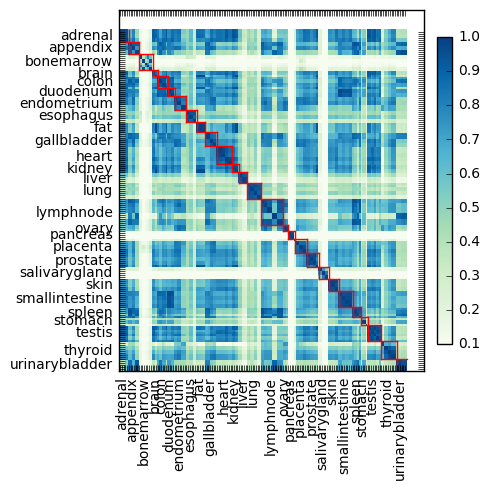

In [18]:
# Within tissues correlation

mm = get_correlation_other_tissue(df_exp2_all, 'Experiment 2 RAW')
tissues_map = create_tissue_map(df_exp2_all)
within_tissue_correlation_heatmap(df_exp2_all, tissues_map, vmin = 0.1)

### 2.2 Apply different normalization and calculate correlation

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adrenal              		 15         		 0.974560   	 0.801104  
appendix             		 15         		 0.962468   	 0.813413  
bonemarrow           		 28         		 0.947439   	 0.711688  
brain                		 3          		 0.933571   	 0.697700  
colon                		 15         		 0.951689   	 0.799509  
duodenum             		 6          		 0.984690   	 0.772782  
endometrium          		 21         		 0.948062   	 0.808659  
esophagus            		 15         		 0.964395   	 0.776561  
fat                  		 10         		 0.978414   	 0.784593  
gallbladder          		 21         		 0.955326   	 0.817426  
heart                		 36         		 0.962632   	 0.748312  
kidney               		 6          		 0.964278   	 0.769781  
liver                		 10         		 0.977267   	 0.661540  
lung                 		 28         		 0.963982   	 0.811107  
lymphnode            		 78         		 0.944344   	 

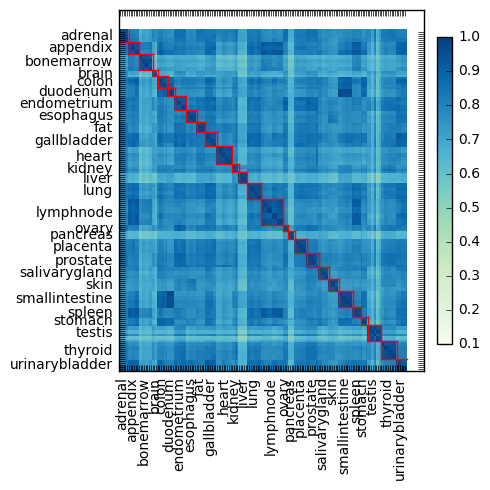

In [19]:
df_exp2_all_yugene = get_yugene_score(df_exp2_all) 

mm = get_correlation_other_tissue(df_exp2_all_yugene, 'Experiment 2 YuGene')
tissues_map = create_tissue_map(df_exp2_all_yugene)
within_tissue_correlation_heatmap(df_exp2_all_yugene, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adrenal              		 15         		 0.979095   	 0.854240  
appendix             		 15         		 0.971938   	 0.862988  
bonemarrow           		 28         		 0.957004   	 0.774958  
brain                		 3          		 0.955225   	 0.779900  
colon                		 15         		 0.964619   	 0.853110  
duodenum             		 6          		 0.984953   	 0.836192  
endometrium          		 21         		 0.962517   	 0.861546  
esophagus            		 15         		 0.969778   	 0.843803  
fat                  		 10         		 0.978987   	 0.844396  
gallbladder          		 21         		 0.968043   	 0.867226  
heart                		 36         		 0.964785   	 0.805113  
kidney               		 6          		 0.972758   	 0.830556  
liver                		 10         		 0.975963   	 0.757429  
lung                 		 28         		 0.969268   	 0.863748  
lymphnode            		 78         		 0.959096   	 

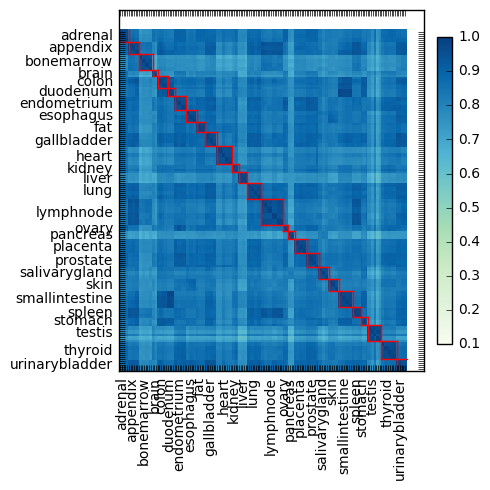

In [20]:
df_exp2_all_ef = get_ef_score(df_exp2_all) 

mm = get_correlation_other_tissue(df_exp2_all_ef, 'Experiment 2 EF Transformed')
tissues_map = create_tissue_map(df_exp2_all_ef)
within_tissue_correlation_heatmap(df_exp2_all_ef, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adrenal              		 15         		 0.944401   	 0.882134  
appendix             		 15         		 0.940993   	 0.887187  
bonemarrow           		 28         		 0.923594   	 0.837970  
brain                		 3          		 0.933582   	 0.850780  
colon                		 15         		 0.934657   	 0.881534  
duodenum             		 6          		 0.946124   	 0.876923  
endometrium          		 21         		 0.932777   	 0.887405  
esophagus            		 15         		 0.940776   	 0.880799  
fat                  		 10         		 0.936938   	 0.880645  
gallbladder          		 21         		 0.940998   	 0.890028  
heart                		 36         		 0.931214   	 0.873119  
kidney               		 6          		 0.941352   	 0.876096  
liver                		 10         		 0.930052   	 0.854844  
lung                 		 28         		 0.932775   	 0.886207  
lymphnode            		 78         		 0.928327   	 

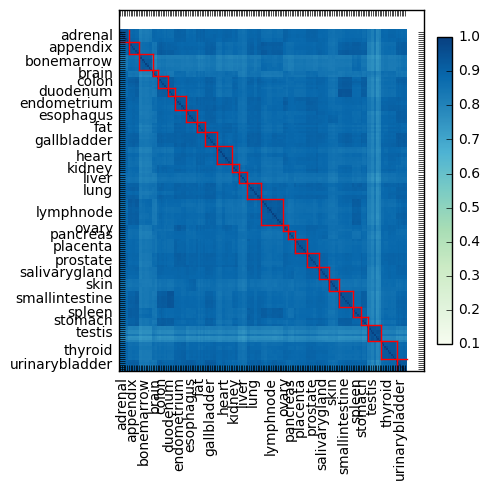

In [21]:
df_exp2_all_rank = get_rank_score(df_exp2_all) 

mm = get_correlation_other_tissue(df_exp2_all_rank, 'Experiment 2 RANK transformed')
tissues_map = create_tissue_map(df_exp2_all_rank)
within_tissue_correlation_heatmap(df_exp2_all_rank, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adrenal              		 15         		 0.977054   	 0.635842  
appendix             		 15         		 0.886764   	 0.583628  
bonemarrow           		 28         		 0.665027   	 0.157861  
brain                		 3          		 0.906303   	 0.585863  
colon                		 15         		 0.908290   	 0.618851  
duodenum             		 6          		 0.973542   	 0.626951  
endometrium          		 21         		 0.885715   	 0.570820  
esophagus            		 15         		 0.939684   	 0.391463  
fat                  		 10         		 0.991353   	 0.528888  
gallbladder          		 21         		 0.907412   	 0.631177  
heart                		 36         		 0.931913   	 0.555071  
kidney               		 6          		 0.952874   	 0.576868  
liver                		 10         		 0.950982   	 0.302630  
lung                 		 28         		 0.937843   	 0.364036  
lymphnode            		 78         		 0.836681   	 

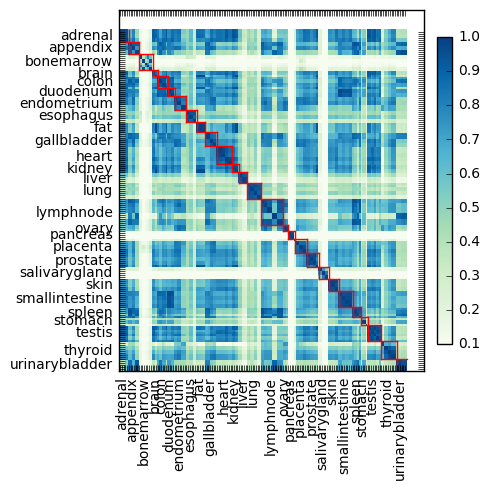

In [22]:
df_exp2_all_zscore = get_zscore_score(df_exp2_all) 

mm = get_correlation_other_tissue(df_exp2_all_zscore, 'Experiment 2 Z-score transformed')
tissues_map = create_tissue_map(df_exp2_all_zscore)
within_tissue_correlation_heatmap(df_exp2_all_zscore, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adrenal              		 15         		 0.984692   	 0.673353  
appendix             		 15         		 0.899570   	 0.623948  
bonemarrow           		 28         		 0.824350   	 0.286502  
brain                		 3          		 0.923418   	 0.621813  
colon                		 15         		 0.904771   	 0.612385  
duodenum             		 6          		 0.975058   	 0.659197  
endometrium          		 21         		 0.784609   	 0.565893  
esophagus            		 15         		 0.961960   	 0.385267  
fat                  		 10         		 0.987428   	 0.566032  
gallbladder          		 21         		 0.832082   	 0.634968  
heart                		 36         		 0.941896   	 0.607548  
kidney               		 6          		 0.951817   	 0.615623  
liver                		 10         		 0.965306   	 0.374714  
lung                 		 28         		 0.931720   	 0.425069  
lymphnode            		 78         		 0.811270   	 

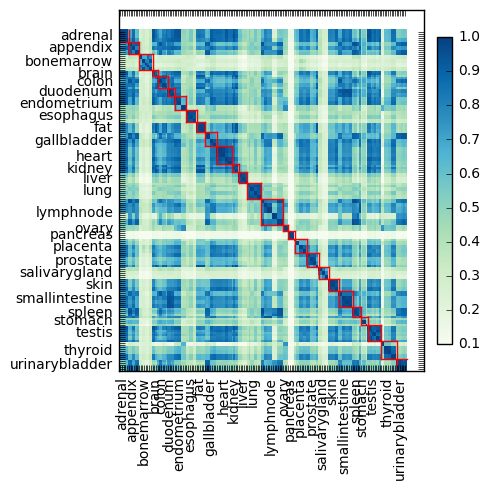

In [23]:
df_exp2_all_quantile = get_quantile_score(df_exp2_all) 

mm = get_correlation_other_tissue(df_exp2_all_quantile, 'Experiment 2 Quantile tranformed')
tissues_map = create_tissue_map(df_exp2_all_quantile)
within_tissue_correlation_heatmap(df_exp2_all_quantile, tissues_map, vmin = 0.1)

Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
adrenal              		 15         		 0.964514   	 0.731959  
appendix             		 15         		 0.944205   	 0.764614  
bonemarrow           		 28         		 0.938078   	 0.666248  
brain                		 3          		 0.917765   	 0.629318  
colon                		 15         		 0.917228   	 0.730753  
duodenum             		 6          		 0.976952   	 0.684838  
endometrium          		 21         		 0.936346   	 0.750490  
esophagus            		 15         		 0.962448   	 0.660900  
fat                  		 10         		 0.974992   	 0.705393  
gallbladder          		 21         		 0.945660   	 0.753001  
heart                		 36         		 0.936806   	 0.597268  
kidney               		 6          		 0.948724   	 0.695713  
liver                		 10         		 0.974123   	 0.476536  
lung                 		 28         		 0.953914   	 0.736572  
lymphnode            		 78         		 0.928817   	 

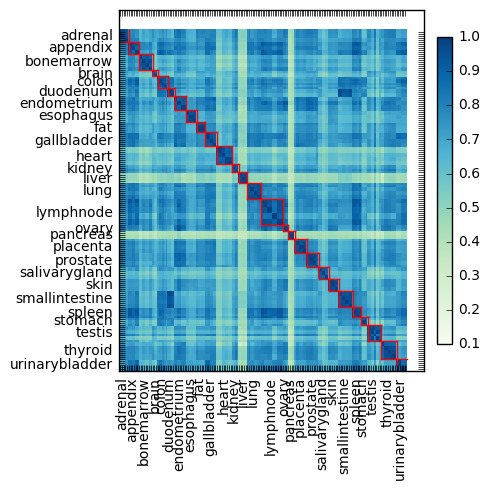

In [24]:
df_exp2_all_quantile = get_sigmoid(df_exp2_all) 

mm = get_correlation_other_tissue(df_exp2_all_quantile, 'Experiment 2 Sigmoid tranformed')
tissues_map = create_tissue_map(df_exp2_all_quantile)
within_tissue_correlation_heatmap(df_exp2_all_quantile, tissues_map, vmin = 0.1)

### 2.3 Substitute some tissue names sothat they are consistent across experiments

In [25]:
cls = list(df_exp1_tissuelv.columns)
cls[1] = 'fat'
cls[cls.index('lymph node')] = 'lymphnode'
cls[cls.index('testes')] = 'testis' 
df_exp1_tissuelv.columns = cls

### 2.4 Only take columns that are common in both experiments (13 in total)

In [26]:
df_exp1_tissuelv2_raw = df_exp1_tissuelv[np.intersect1d(df_exp1_tissuelv.columns, df_exp2_tissuelv.columns)]
df_exp2_tissuelv2_raw = df_exp2_tissuelv[np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns)]

### 2.5 Compare 2 experiments and calculate correlation between gene expression for each tissue

Tissue               		 Correlation 	 Mean other tissues
adrenal              		 0.746598 	 0.620747  
brain                		 0.889714 	 0.657787  
colon                		 0.679275 	 0.599923  
heart                		 0.931571 	 0.671021  
kidney               		 0.893164 	 0.699746  
liver                		 0.699175 	 0.467415  
lung                 		 0.527385 	 0.528945  
ovary                		 0.872747 	 0.598897  
prostate             		 0.771987 	 0.645039  
thyroid              		 0.776122 	 0.668974  
Average within tissue correlation across experiments (RAW 1-2 data) = 0.778773742356
MEDIAN within tissue correlation across experiments (RAW 1-2 data) = 0.774054403337
Average all other tissue correlation = 0.615849334893
MEDIAN all other tissue correlation = 0.632892848075


(0.77877374235597951, 0.61584933489327498)

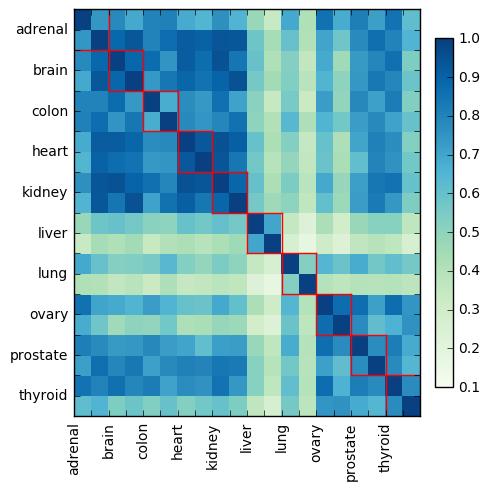

In [37]:
df_exp1_all_mean = find_average_abundance_tissue(df_exp1_all)
df_exp2_all_mean = find_average_abundance_tissue(df_exp2_all)

ddf1 = df_exp1_all_mean[np.intersect1d(df_exp1_all_mean.columns, df_exp2_all_mean.columns)]
ddf2 = df_exp2_all_mean[np.intersect1d(df_exp2_all_mean.columns, df_exp1_all_mean.columns)]

print_corr_and_heatmap(ddf1, ddf2, "RAW 1-2", vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
adrenal              		 0.847931 	 0.805591  
brain                		 0.957440 	 0.733794  
colon                		 0.853909 	 0.817377  
heart                		 0.960269 	 0.748427  
kidney               		 0.944984 	 0.822508  
liver                		 0.935603 	 0.653180  
lung                 		 0.913556 	 0.776151  
ovary                		 0.936534 	 0.826590  
prostate             		 0.909267 	 0.831240  
thyroid              		 0.911281 	 0.817914  
Average within tissue correlation across experiments (YuGene 1-2 data) = 0.917077481625
MEDIAN within tissue correlation across experiments (YuGene 1-2 data) = 0.924579645718
Average all other tissue correlation = 0.783277245338
MEDIAN all other tissue correlation = 0.811483744894


(0.917077481624893, 0.78327724533756138)

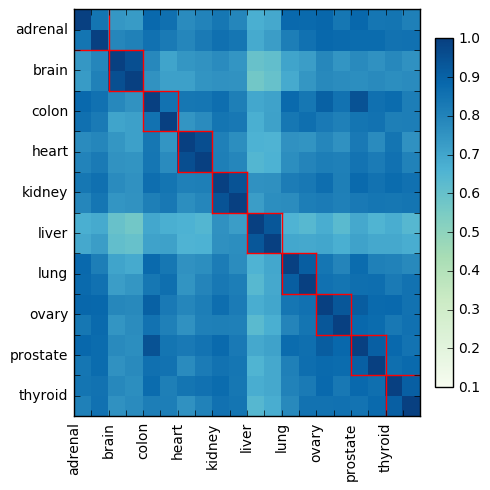

In [38]:
df_exp1_all_mean = find_average_abundance_tissue(get_yugene_score(df_exp1_all))
df_exp2_all_mean = find_average_abundance_tissue(get_yugene_score(df_exp2_all))

ddf1 = df_exp1_all_mean[np.intersect1d(df_exp1_all_mean.columns, df_exp2_all_mean.columns)]
ddf2 = df_exp2_all_mean[np.intersect1d(df_exp2_all_mean.columns, df_exp1_all_mean.columns)]

print_corr_and_heatmap(ddf1, ddf2, "YuGene 1-2", vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
adrenal              		 0.884664 	 0.852913  
brain                		 0.963529 	 0.797919  
colon                		 0.884127 	 0.852102  
heart                		 0.963529 	 0.794102  
kidney               		 0.960890 	 0.863228  
liver                		 0.948121 	 0.735908  
lung                 		 0.930183 	 0.826780  
ovary                		 0.951243 	 0.872781  
prostate             		 0.938211 	 0.877671  
thyroid              		 0.938845 	 0.869029  
Average within tissue correlation across experiments (EF Transformed 1-2 data) = 0.936334305263
MEDIAN within tissue correlation across experiments (EF Transformed 1-2 data) = 0.943483419562
Average all other tissue correlation = 0.834243351084
MEDIAN all other tissue correlation = 0.852507591252


(0.93633430526301109, 0.8342433510840056)

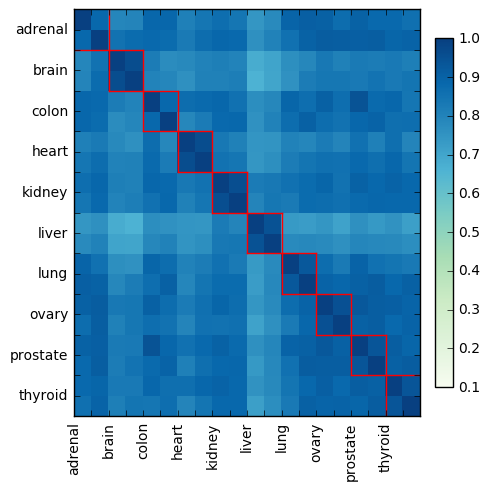

In [39]:
df_exp1_all_mean = find_average_abundance_tissue(get_ef_score(df_exp1_all))
df_exp2_all_mean = find_average_abundance_tissue(get_ef_score(df_exp2_all))

ddf1 = df_exp1_all_mean[np.intersect1d(df_exp1_all_mean.columns, df_exp2_all_mean.columns)]
ddf2 = df_exp2_all_mean[np.intersect1d(df_exp2_all_mean.columns, df_exp1_all_mean.columns)]

print_corr_and_heatmap(ddf1, ddf2, "EF Transformed 1-2", vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
adrenal              		 0.708677 	 0.592373  
brain                		 0.867322 	 0.641279  
colon                		 0.676546 	 0.609044  
heart                		 0.938284 	 0.679822  
kidney               		 0.889490 	 0.710779  
liver                		 0.794139 	 0.443068  
lung                 		 0.533453 	 0.506577  
ovary                		 0.740777 	 0.595953  
prostate             		 0.660376 	 0.624212  
thyroid              		 0.707897 	 0.646158  
Average within tissue correlation across experiments (Quantile Transformed 1-2 data) = 0.751696040912
MEDIAN within tissue correlation across experiments (Quantile Transformed 1-2 data) = 0.724726990617
Average all other tissue correlation = 0.60492646805
MEDIAN all other tissue correlation = 0.616628047928


(0.75169604091214715, 0.60492646805000316)

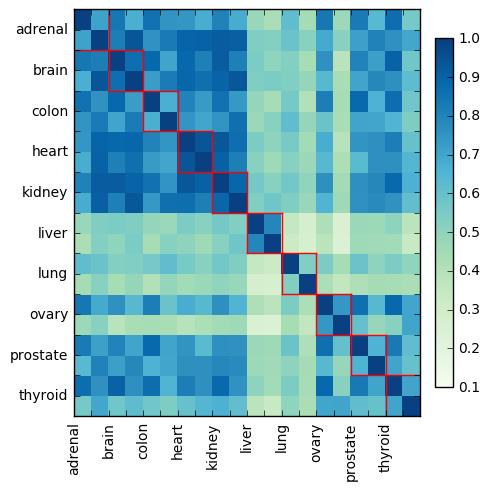

In [40]:
df_exp1_all_mean = find_average_abundance_tissue(get_quantile_score(df_exp1_all))
df_exp2_all_mean = find_average_abundance_tissue(get_quantile_score(df_exp2_all))

ddf1 = df_exp1_all_mean[np.intersect1d(df_exp1_all_mean.columns, df_exp2_all_mean.columns)]
ddf2 = df_exp2_all_mean[np.intersect1d(df_exp2_all_mean.columns, df_exp1_all_mean.columns)]

print_corr_and_heatmap(ddf1, ddf2, "Quantile Transformed 1-2", vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
adrenal              		 0.899597 	 0.893099  
brain                		 0.950953 	 0.877663  
colon                		 0.927991 	 0.907205  
heart                		 0.949695 	 0.899017  
kidney               		 0.950776 	 0.907734  
liver                		 0.949228 	 0.884018  
lung                 		 0.946201 	 0.895714  
ovary                		 0.938073 	 0.908852  
prostate             		 0.943653 	 0.914837  
thyroid              		 0.939876 	 0.908733  
Average within tissue correlation across experiments (RANK Transformed 1-2 data) = 0.939604375875
MEDIAN within tissue correlation across experiments (RANK Transformed 1-2 data) = 0.944927339031
Average all other tissue correlation = 0.899687224335
MEDIAN all other tissue correlation = 0.903111351124


(0.93960437587497747, 0.89968722433546833)

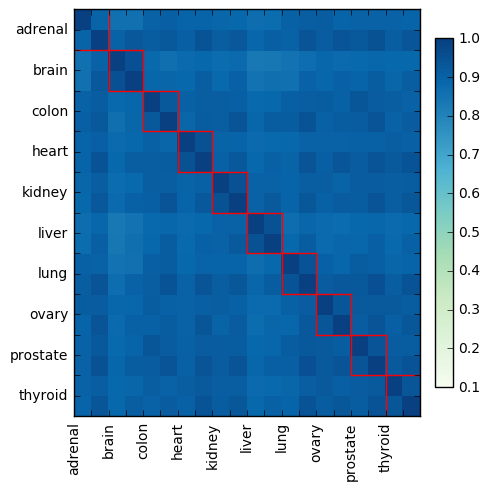

In [41]:
df_exp1_all_mean = find_average_abundance_tissue(get_rank_score(df_exp1_all))
df_exp2_all_mean = find_average_abundance_tissue(get_rank_score(df_exp2_all))

ddf1 = df_exp1_all_mean[np.intersect1d(df_exp1_all_mean.columns, df_exp2_all_mean.columns)]
ddf2 = df_exp2_all_mean[np.intersect1d(df_exp2_all_mean.columns, df_exp1_all_mean.columns)]

print_corr_and_heatmap(ddf1, ddf2, "RANK Transformed 1-2", vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
adrenal              		 0.808662 	 0.749567  
brain                		 0.945276 	 0.653666  
colon                		 0.794484 	 0.749154  
heart                		 0.936181 	 0.595997  
kidney               		 0.905768 	 0.741891  
liver                		 0.898574 	 0.472702  
lung                 		 0.899438 	 0.713372  
ovary                		 0.941202 	 0.749193  
prostate             		 0.894810 	 0.751545  
thyroid              		 0.885641 	 0.749316  
Average within tissue correlation across experiments (Sigmoid Transformed 1-2 data) = 0.891003564242
MEDIAN within tissue correlation across experiments (Sigmoid Transformed 1-2 data) = 0.899005870779
Average all other tissue correlation = 0.692640494277
MEDIAN all other tissue correlation = 0.745522718229


(0.89100356424207594, 0.69264049427681229)

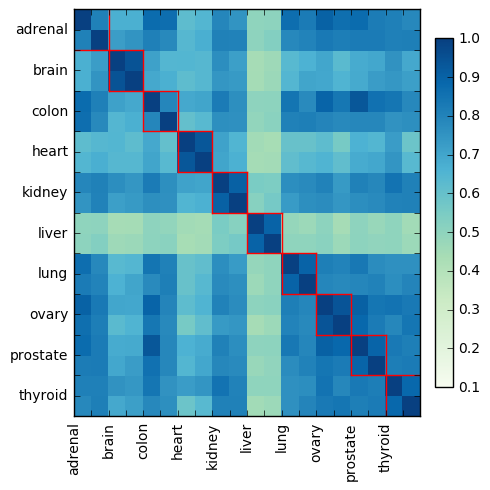

In [42]:
df_exp1_all_mean = find_average_abundance_tissue(get_sigmoid(df_exp1_all))
df_exp2_all_mean = find_average_abundance_tissue(get_sigmoid(df_exp2_all))

ddf1 = df_exp1_all_mean[np.intersect1d(df_exp1_all_mean.columns, df_exp2_all_mean.columns)]
ddf2 = df_exp2_all_mean[np.intersect1d(df_exp2_all_mean.columns, df_exp1_all_mean.columns)]

print_corr_and_heatmap(ddf1, ddf2, "Sigmoid Transformed 1-2", vmin = 0.1)

# 3. Experiment 3: The evolution of gene expression levels in mammalian organs / GSF911938 

In [43]:
basedir = './Experiment GSF911938/Exported_on_2017-02-10_14_14_00'

df_reports_exp3, metainfo_exp3 = read_kallisto_results_tpms(basedir)

# find additional metainfo (extracted separately from Genestack with python script)
metainf3 = pd.read_csv('./Experiment GSF911938/metainfo.csv', sep = '\t',index_col=False)
display(metainf3.head())

# read kallisto reports to pandas dataframes and create dictionary kallisto_counts for each file accession. 
# do the same with kallisto metainfo and combine it with columns in additional metainfo.
kallisto_metainfo = defaultdict()
for i, filename in enumerate(metainfo_exp3):
    print i,
    if i%100 == 0 and i>0:
        clear_output()
    meta = pd.read_csv(filename, sep = ',')[['Source data', 'Name']]
    acc = meta['Source data'].values[0].split('/ ')[1]
    metainf3.ix[metainf3['genestack:accession']==acc ,'genestack:name'] = filename.split('Kallisto_Report_for_')[1].split('/')[0].split('__metainfo')[0]
    kallisto_metainfo[filename.split('Kallisto_Report_for_')[1].split('/')[0].split('__metainfo')[0]] = metainf3[metainf3['genestack:accession']==acc]

# Create pandas dataframe for metainfo so we can map accessions with file names
df_meta = pd.DataFrame(kallisto_metainfo[kallisto_metainfo.keys()[0]], columns=[kallisto_metainfo.values()[0].columns])
for key in kallisto_metainfo.keys()[1::]:
    df_meta = pd.concat([df_meta, kallisto_metainfo[key].copy()])
df_meta = df_meta.reset_index(drop=True)

display(df_meta.head(3))

# in this experiment "sourceData:sra.sample_attribute:[source_name]" is a tissue name
cl = [df_meta[df_meta['genestack:name']==x]['sourceData:sra.sample_attribute:[source_name]'].values[0] for x in df_reports_exp3.columns]
df_exp3_all = df_reports_exp3.copy()
df_exp3_all.columns = cl

# If there are duplicate columns - enumerate them and add "_number of duplicate" at the end of tissue name
cols=pd.Series(df_exp3_all.columns)
for dup in df_exp3_all.columns.get_duplicates(): cols[df_exp3_all.columns.get_loc(dup)]=[dup+'_'+str(d_idx+1) if d_idx!=0 else dup+'_0' for d_idx in range(df_exp3_all.columns.get_loc(dup).sum())]
df_exp3_all.columns=cols
display(df_exp3_all.head(3))

# calculate average values across replicates for same tissue
df_exp3_tissuelv = find_average_abundance_tissue(df_exp3_all).copy()
df_exp3_tissuelv.head()

Number of reports found =  21 
Name of first report: ./Experiment GSF911938/Exported_on_2017-02-10_14_14_00/Kallisto_Report_for_hsa_br_F_1/GSF3764966_kallisto_abundance_genes.tsv
Processing report #:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

,genestack:accession,genestack:name,genestack.bio:sex,sourceData:sra.sample_attribute:[source_name]
0,GSF911989,hsa ht F 1,female,Heart
1,GSF911988,hsa cb F 1,female,Cerebellum
2,GSF912024,hsa lv M 1 (run 2),male,Liver
3,GSF912016,hsa ts M 2,male,Testis
4,GSF912017,hsa kd M 1,male,Kidney


 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

,genestack:accession,genestack:name,genestack.bio:sex,sourceData:sra.sample_attribute:[source_name]
0,GSF912021,hsa_lv_M_2,male,Liver
1,GSF912019,hsa_ht_M_2,male,Heart
2,GSF912022,hsa_ts_M_1,male,Testis


,Liver_0,Heart_0,Testis_0,Testis_2,Kidney_0,Cerebellum_0,"Brain, prefrontal cortex_0","Brain, prefrontal cortex_2","Brain, frontal cortex_0","Brain, prefrontal cortex_3",...,"Brain, frontal cortex_2",Liver_2,Heart_2,Cerebellum_2,Heart_3,Kidney_2,Kidney_3,Heart_4,Liver_3,Cerebellum_3
ENSG00000000003,29.66,3.79,57.77,132.94,17.81,2.49,9.83,6.05,2.98,5.56,...,5.63,30.71,3.09,3.83,4.49,14.10,23.40,3.03,36.42,2.21
ENSG00000000005,0.06,0.41,0.24,0.15,0.52,0.36,0.18,0.36,0.12,0.00,...,0.08,0.00,0.00,0.00,0.37,0.05,0.15,0.00,0.00,0.00
ENSG00000000419,15.61,23.27,14.95,23.97,15.51,11.93,19.32,19.27,4.42,11.40,...,18.08,11.55,11.03,8.36,9.43,11.26,6.58,14.30,12.40,13.74


,"Brain, frontal cortex","Brain, prefrontal cortex","Brain, temporal lobe",Cerebellum,Heart,Kidney,Liver,Testis
ENSG00000000003,4.305,7.146667,5.05,2.843333,3.6000,18.436667,32.263333,95.355
ENSG00000000005,0.100,0.180000,0.00,0.120000,0.1950,0.240000,0.020000,0.195
ENSG00000000419,11.250,16.663333,8.92,11.343333,14.5075,11.116667,13.186667,19.460
ENSG00000000457,2.740,4.620000,1.45,3.733333,1.8225,2.600000,2.466667,5.605
ENSG00000000460,1.900,3.880000,1.14,2.453333,0.8375,0.756667,1.063333,11.780


In [44]:
# in this experiment there were different "brain" tissues like "cerebellum" or "Brain, temporal lobe"
# to compare experiments let's average them to get one "brain" tissue
df_exp3_all_brain = df_exp3_all.copy()

brc = ['Brain, frontal cortex','Brain, prefrontal cortex', 'Brain, temporal lobe', 'Cerebellum']
cols = df_exp3_all.columns.values
df_exp3_all_brain.columns = ['Brain' if c.split('_')[0] in brc else c for c in cols]

cols = pd.Series(df_exp3_all.columns)
for dup in df_exp3_all_brain.columns.get_duplicates(): cols[df_exp3_all_brain.columns.get_loc(dup)]=[dup+'_'+str(d_idx+1) if d_idx!=0 else dup for d_idx in range(df_exp3_all_brain.columns.get_loc(dup).sum())]
df_exp3_all_brain.columns=cols

df_exp3_all_brain.columns = [x.lower() for x in df_exp3_all_brain.columns.values]

df_exp3_all_brain.head()

,liver_0,heart_0,testis_0,testis_2,kidney_0,brain,brain_2,brain_3,brain_4,brain_5,...,brain_7,liver_2,heart_2,brain_8,heart_3,kidney_2,kidney_3,heart_4,liver_3,brain_9
ENSG00000000003,29.66,3.79,57.77,132.94,17.81,2.49,9.83,6.05,2.98,5.56,...,5.63,30.71,3.09,3.83,4.49,14.10,23.40,3.03,36.42,2.21
ENSG00000000005,0.06,0.41,0.24,0.15,0.52,0.36,0.18,0.36,0.12,0.00,...,0.08,0.00,0.00,0.00,0.37,0.05,0.15,0.00,0.00,0.00
ENSG00000000419,15.61,23.27,14.95,23.97,15.51,11.93,19.32,19.27,4.42,11.40,...,18.08,11.55,11.03,8.36,9.43,11.26,6.58,14.30,12.40,13.74
ENSG00000000457,2.95,2.18,5.55,5.66,3.34,4.36,5.99,3.94,2.33,3.93,...,3.15,1.77,1.58,1.97,1.42,1.84,2.62,2.11,2.68,4.87
ENSG00000000460,0.94,0.76,10.58,12.98,0.59,2.56,2.87,1.93,1.94,6.84,...,1.86,1.40,0.80,2.60,0.81,0.76,0.92,0.98,0.85,2.20


Tissue               	 number of comparisons 		 Correlation 	 Mean other tissues
Brain, frontal cortex 		 9          		 0.900544   	 0.809281  
Brain, prefrontal cortex 		 12         		 0.843510   	 0.739226  
Brain, temporal lobe 		 5          		 0.901351   	 0.802907  
Cerebellum           		 3          		 0.954880   	 0.815792  
Heart                		 6          		 0.864409   	 0.766601  
Kidney               		 3          		 0.911365   	 0.779095  
Liver                		 3          		 0.931489   	 0.535107  
Testis               		 1          		 0.766105   	 0.645122  
Average within tissue correlation (Experiment 3 RAW data) = 0.884206697894
MEDIAN within tissue correlation across experiments = 0.900947645673
Average all other tissue correlation = 0.736641349084
MEDIAN all other tissue correlation = 0.772847921234


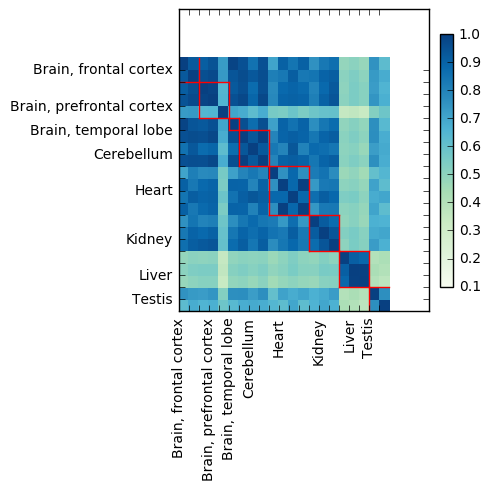

In [45]:
mm = get_correlation_other_tissue(df_exp3_all, 'Experiment 3 RAW')
tissues_map = create_tissue_map(df_exp3_all)
within_tissue_correlation_heatmap(df_exp3_all, tissues_map, vmin = 0.1)

In [47]:
# let's combine different "brain" columns into one for averaged data as well
df_exp3_tissuelv_brain = df_exp3_tissuelv.copy()
df_exp3_tissuelv_brain['brain'] = df_exp3_tissuelv_brain[['Brain, frontal cortex','Brain, prefrontal cortex', 'Brain, temporal lobe', 'Cerebellum']].mean(axis=1)
df_exp3_tissuelv_brain = df_exp3_tissuelv_brain.drop(['Brain, frontal cortex','Brain, prefrontal cortex', 'Brain, temporal lobe', 'Cerebellum'], axis=1)
df_exp3_tissuelv_brain.columns = [x.lower() for x in df_exp3_tissuelv_brain.columns.values]
df_exp3_tissuelv_brain.head()

,heart,kidney,liver,testis,brain
ENSG00000000003,3.6000,18.436667,32.263333,95.355,4.836250
ENSG00000000005,0.1950,0.240000,0.020000,0.195,0.100000
ENSG00000000419,14.5075,11.116667,13.186667,19.460,12.044167
ENSG00000000457,1.8225,2.600000,2.466667,5.605,3.135833
ENSG00000000460,0.8375,0.756667,1.063333,11.780,2.343333


Tissue               		 Correlation 	 Mean other tissues
brain                		 0.900113 	 0.745985  
heart                		 0.911551 	 0.747592  
kidney               		 0.866069 	 0.749069  
liver                		 0.800509 	 0.499263  
testis               		 0.810801 	 0.718406  
Average within tissue correlation across experiments (RAW all 3 exp data) = 0.857808221515
MEDIAN within tissue correlation across experiments (RAW all 3 exp data) = 0.866068556291
Average all other tissue correlation = 0.692062875408
MEDIAN all other tissue correlation = 0.745985108445


([0.90011250846900248,
  0.91155083661551228,
  0.86606855629096002,
  0.80050863619285417,
  0.81080057000608252],
 [0.74598510844502675,
  0.74759242854816133,
  0.74906863627294451,
  0.49926268674210261,
  0.71840551703297739])

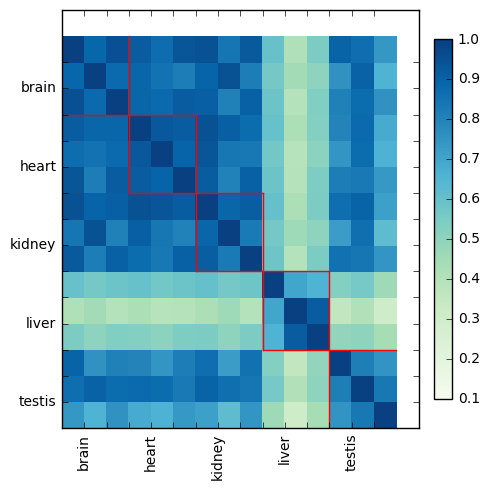

In [48]:
df_exp1_tissuelv2 = df_exp1_tissuelv[np.intersect1d(np.intersect1d(df_exp1_tissuelv.columns, df_exp2_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp2_tissuelv2 = df_exp2_tissuelv[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp3_tissuelv2 = df_exp3_tissuelv_brain[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain.columns)]

print_corr_and_heatmap_3exp(df_exp1_tissuelv2, df_exp2_tissuelv2, df_exp3_tissuelv2, 'RAW all 3 exp', show = True, vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
brain                		 0.930756 	 0.676722  
heart                		 0.935818 	 0.689988  
kidney               		 0.929369 	 0.738196  
liver                		 0.931515 	 0.619557  
testis               		 0.911785 	 0.683033  
Average within tissue correlation across experiments (Yugene all 3 exp data) = 0.927848610293
MEDIAN within tissue correlation across experiments (Yugene all 3 exp data) = 0.930755910426
Average all other tissue correlation = 0.681499426184
MEDIAN all other tissue correlation = 0.683033485597


([0.93075591042589689,
  0.93581807884040213,
  0.92936943912516967,
  0.93151473745183944,
  0.9117848856209394],
 [0.67672229530182093,
  0.68998818346353474,
  0.73819601031494175,
  0.61955715624255658,
  0.6830334855974266])

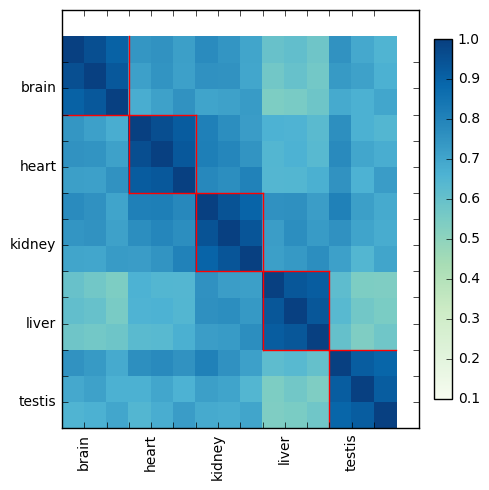

In [68]:
df_exp1_tissuelv_yugene = find_average_abundance_tissue(get_yugene_score(df_exp1_all))
cls = list(df_exp1_tissuelv_yugene.columns)
cls[1] = 'fat'
cls[cls.index('lymph node')] = 'lymphnode'
cls[cls.index('testes')] = 'testis' 
df_exp1_tissuelv_yugene.columns = cls

df_exp2_tissuelv_yugene = find_average_abundance_tissue(get_yugene_score(df_exp2_all))
df_exp3_tissuelv_brain_yugene = find_average_abundance_tissue(get_yugene_score(df_exp3_all_brain))

df_exp1_tissuelv2_yugene = df_exp1_tissuelv_yugene[np.intersect1d(np.intersect1d(df_exp1_tissuelv.columns, df_exp2_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp2_tissuelv2_yugene = df_exp2_tissuelv_yugene[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp3_tissuelv2_yugene = df_exp3_tissuelv_brain_yugene[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain_yugene.columns)]

print_corr_and_heatmap_3exp(df_exp1_tissuelv2_yugene, df_exp2_tissuelv2_yugene, df_exp3_tissuelv2_yugene, 'Yugene all 3 exp', show = True, vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
brain                		 0.925026 	 0.619399  
heart                		 0.917311 	 0.579393  
kidney               		 0.914368 	 0.662069  
liver                		 0.915551 	 0.461587  
testis               		 0.893718 	 0.641261  
Average within tissue correlation across experiments (Sigmoid all 3 data) = 0.913194593638
MEDIAN within tissue correlation across experiments (Sigmoid all 3 data) = 0.91555145041
Average all other tissue correlation = 0.592741931299
MEDIAN all other tissue correlation = 0.619398726977


([0.92502585583687491,
  0.91731050641866352,
  0.91436754840975909,
  0.91555145040992159,
  0.89371760711419634],
 [0.61939872697681875,
  0.57939348466223073,
  0.66206932109985461,
  0.4615874184153847,
  0.64126070533885693])

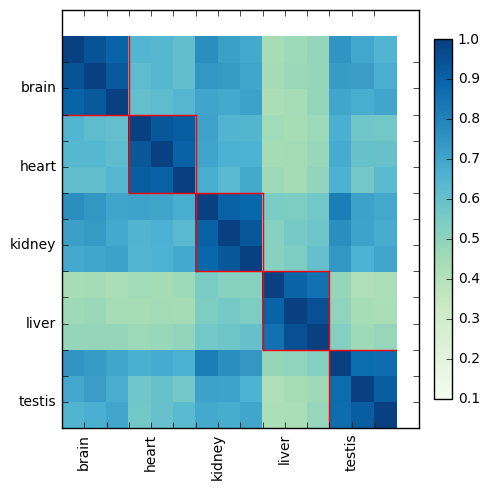

In [80]:
df_exp1_tissuelv_sigm = find_average_abundance_tissue(get_sigmoid(df_exp1_all))
cls = list(df_exp1_tissuelv_sigm.columns)
cls[1] = 'fat'
cls[cls.index('lymph node')] = 'lymphnode'
cls[cls.index('testes')] = 'testis' 
df_exp1_tissuelv_sigm.columns = cls

df_exp2_tissuelv_sigm = find_average_abundance_tissue(get_sigmoid(df_exp2_all))
df_exp3_tissuelv_brain_sigm = find_average_abundance_tissue(get_sigmoid(df_exp3_all_brain))

df_exp1_tissuelv2_sigm = df_exp1_tissuelv_sigm[np.intersect1d(np.intersect1d(df_exp1_tissuelv_sigm.columns, df_exp2_tissuelv_sigm.columns), df_exp3_tissuelv_brain_sigm.columns)]
df_exp2_tissuelv2_sigme = df_exp2_tissuelv_sigm[np.intersect1d(np.intersect1d(df_exp2_tissuelv_sigm.columns, df_exp1_tissuelv_sigm.columns), df_exp3_tissuelv_brain_sigm.columns)]
df_exp3_tissuelv2_sigm = df_exp3_tissuelv_brain_sigm[np.intersect1d(np.intersect1d(df_exp2_tissuelv_sigm.columns, df_exp1_tissuelv_sigm.columns), df_exp3_tissuelv_brain_sigm.columns)]

print_corr_and_heatmap_3exp(df_exp1_tissuelv2_sigm, df_exp2_tissuelv2_sigme, df_exp3_tissuelv2_sigm, 'Sigmoid all 3', show = True, vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
brain                		 0.910755 	 0.750890  
heart                		 0.909697 	 0.749169  
kidney               		 0.869140 	 0.753762  
liver                		 0.802993 	 0.503561  
testis               		 0.823325 	 0.721696  
Average within tissue correlation across experiments (Z score all 3 exp data) = 0.863182171458
MEDIAN within tissue correlation across experiments (Z score all 3 exp data) = 0.869139683139
Average all other tissue correlation = 0.695815768815
MEDIAN all other tissue correlation = 0.749169285239


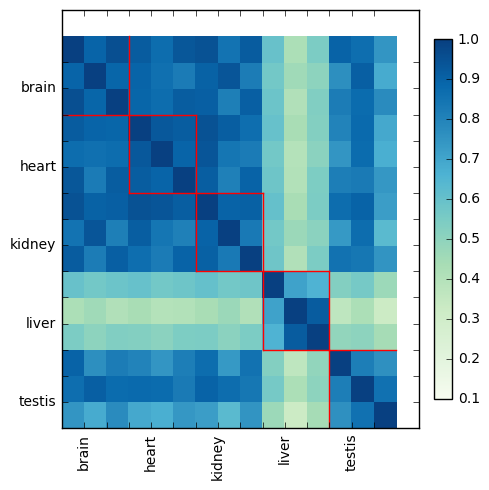

In [70]:
df_exp1_tissuelv_z = find_average_abundance_tissue(get_zscore_score(df_exp1_all))
cls = list(df_exp1_tissuelv_z.columns)
cls[1] = 'fat'
cls[cls.index('lymph node')] = 'lymphnode'
cls[cls.index('testes')] = 'testis' 
df_exp1_tissuelv_z.columns = cls

df_exp2_tissuelv_z = find_average_abundance_tissue(get_zscore_score(df_exp2_all))
df_exp3_tissuelv_brain_z = find_average_abundance_tissue(get_zscore_score(df_exp3_all_brain))

df_exp1_tissuelv2_z = df_exp1_tissuelv_z[np.intersect1d(np.intersect1d(df_exp1_tissuelv.columns, df_exp2_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp2_tissuelv2_z = df_exp2_tissuelv_z[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp3_tissuelv2_z = df_exp3_tissuelv_brain_z[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain_z.columns)]

x1,x2 = print_corr_and_heatmap_3exp(df_exp1_tissuelv2_z, df_exp2_tissuelv2_z, df_exp3_tissuelv2_z, 'Z score all 3 exp', show = True, vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
brain                		 0.950188 	 0.744878  
heart                		 0.942596 	 0.748326  
kidney               		 0.944512 	 0.796314  
liver                		 0.939969 	 0.708353  
testis               		 0.936551 	 0.741437  
Average within tissue correlation across experiments (EF all 3 exp data) = 0.942763255789
MEDIAN within tissue correlation across experiments (EF all 3 exp data) = 0.942596206473
Average all other tissue correlation = 0.747861730433
MEDIAN all other tissue correlation = 0.744878031739


([0.95018845849629452,
  0.9425962064725788,
  0.94451207186058994,
  0.9399685934645865,
  0.93655094865293387],
 [0.74487803173893508,
  0.74832638448598487,
  0.79631434269158508,
  0.70835257668174589,
  0.74143731656537948])

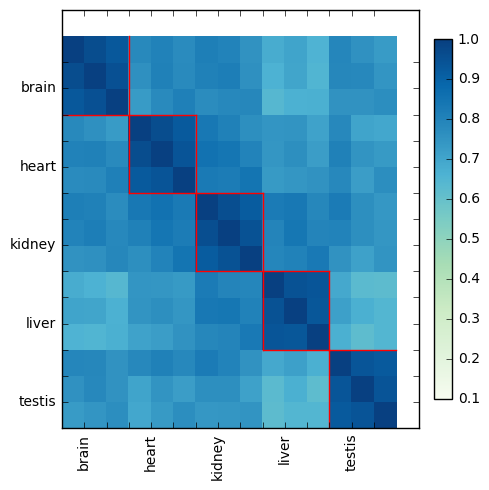

In [71]:
df_exp1_tissuelv_ef = find_average_abundance_tissue(get_ef_score(df_exp1_all))
cls = list(df_exp1_tissuelv_ef.columns)
cls[1] = 'fat'
cls[cls.index('lymph node')] = 'lymphnode'
cls[cls.index('testes')] = 'testis' 
df_exp1_tissuelv_ef.columns = cls

df_exp2_tissuelv_ef = find_average_abundance_tissue(get_ef_score(df_exp2_all))
df_exp3_tissuelv_brain_ef = find_average_abundance_tissue(get_ef_score(df_exp3_all_brain))

df_exp1_tissuelv2_ef = df_exp1_tissuelv_ef[np.intersect1d(np.intersect1d(df_exp1_tissuelv.columns, df_exp2_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp2_tissuelv2_ef = df_exp2_tissuelv_ef[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp3_tissuelv2_ef = df_exp3_tissuelv_brain_ef[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain_ef.columns)]

print_corr_and_heatmap_3exp(df_exp1_tissuelv2_ef, df_exp2_tissuelv2_ef, df_exp3_tissuelv2_ef, 'EF all 3 exp', show = True, vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
brain                		 0.954355 	 0.855385  
heart                		 0.948968 	 0.868814  
kidney               		 0.950622 	 0.877479  
liver                		 0.945438 	 0.855999  
testis               		 0.943103 	 0.835576  
Average within tissue correlation across experiments (RANK all 3 exp data) = 0.948497208608
MEDIAN within tissue correlation across experiments (RANK all 3 exp data) = 0.948968426257
Average all other tissue correlation = 0.858650506932
MEDIAN all other tissue correlation = 0.855998697001


([0.95435451934609428,
  0.94896842625660272,
  0.9506221584844281,
  0.94543824868451853,
  0.94310269027030613],
 [0.85538494120877395,
  0.86881424482020309,
  0.87747897461692581,
  0.85599869700086639,
  0.83557567701368873])

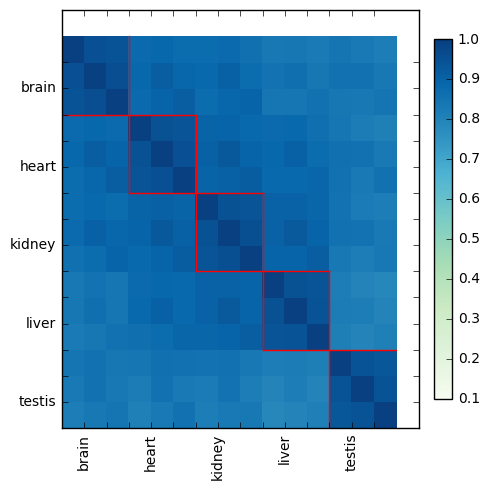

In [72]:
df_exp1_tissuelv_rank = find_average_abundance_tissue(get_rank_score(df_exp1_all))
cls = list(df_exp1_tissuelv_rank.columns)
cls[1] = 'fat'
cls[cls.index('lymph node')] = 'lymphnode'
cls[cls.index('testes')] = 'testis' 
df_exp1_tissuelv_rank.columns = cls

df_exp2_tissuelv_rank = find_average_abundance_tissue(get_rank_score(df_exp2_all))
df_exp3_tissuelv_brain_rank = find_average_abundance_tissue(get_rank_score(df_exp3_all_brain))

df_exp1_tissuelv2_rank = df_exp1_tissuelv_rank[np.intersect1d(np.intersect1d(df_exp1_tissuelv.columns, df_exp2_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp2_tissuelv2_rank = df_exp2_tissuelv_rank[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp3_tissuelv2_rank = df_exp3_tissuelv_brain_rank[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain_rank.columns)]

print_corr_and_heatmap_3exp(df_exp1_tissuelv2_rank, df_exp2_tissuelv2_rank, df_exp3_tissuelv2_rank, 'RANK all 3 exp', show = True, vmin = 0.1)

Tissue               		 Correlation 	 Mean other tissues
brain                		 0.892456 	 0.732006  
heart                		 0.901697 	 0.739193  
kidney               		 0.848772 	 0.750427  
liver                		 0.792162 	 0.502539  
testis               		 0.769408 	 0.728339  
Average within tissue correlation across experiments (Quantile all 3 exp data) = 0.840898857761
MEDIAN within tissue correlation across experiments (Quantile all 3 exp data) = 0.848772494132
Average all other tissue correlation = 0.690500673378
MEDIAN all other tissue correlation = 0.732005649314


([0.89245590379987139,
  0.90169656319468228,
  0.8487724941317365,
  0.79216159861694124,
  0.76940772906164734],
 [0.73200564931403633,
  0.73919296331057327,
  0.75042726648152669,
  0.50253880710940113,
  0.72833868067610918])

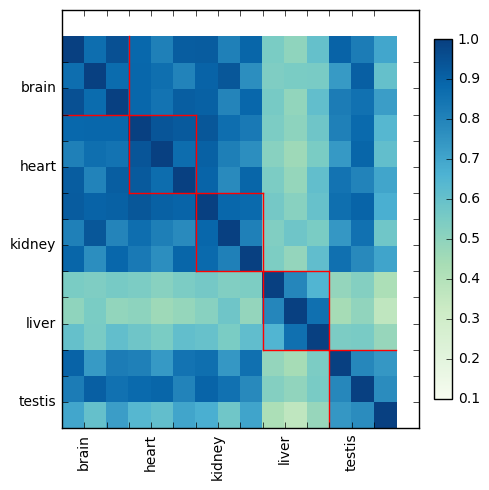

In [73]:
df_exp1_tissuelv_yugene = find_average_abundance_tissue(get_quantile_score(df_exp1_all))
cls = list(df_exp1_tissuelv_yugene.columns)
cls[1] = 'fat'
cls[cls.index('lymph node')] = 'lymphnode'
cls[cls.index('testes')] = 'testis' 
df_exp1_tissuelv_yugene.columns = cls

df_exp2_tissuelv_yugene = find_average_abundance_tissue(get_quantile_score(df_exp2_all))
df_exp3_tissuelv_brain_yugene = find_average_abundance_tissue(get_quantile_score(df_exp3_all_brain))

df_exp1_tissuelv2_yugene = df_exp1_tissuelv_yugene[np.intersect1d(np.intersect1d(df_exp1_tissuelv.columns, df_exp2_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp2_tissuelv2_yugene = df_exp2_tissuelv_yugene[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain.columns)]
df_exp3_tissuelv2_yugene = df_exp3_tissuelv_brain_yugene[np.intersect1d(np.intersect1d(df_exp2_tissuelv.columns, df_exp1_tissuelv.columns), df_exp3_tissuelv_brain_yugene.columns)]

print_corr_and_heatmap_3exp(df_exp1_tissuelv2_yugene, df_exp2_tissuelv2_yugene, df_exp3_tissuelv2_yugene, 'Quantile all 3 exp', show = True, vmin = 0.1)